# Neuroprosthetics Exercise 7 - Alexander Koenig

## Subtask 1 - Border Frequencies of a Filter

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy import signal

np.seterr(divide = 'ignore')

rcParams['font.family'] = "Arial"
rcParams['xtick.labelsize'] = 11
rcParams['ytick.labelsize'] = 11
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 12
rcParams['axes.grid'] = True

In [2]:
class CochlearImplant:
    
    def __init__(self, electrodes, verbose=False):
        self.f_lowest = 100
        self.f_highest = 8000
        self.electrodes = electrodes
        self.f_border = np.logspace(np.log10(self.f_lowest), np.log10(self.f_highest), num=electrodes+1) 
        
        if verbose: 
            print(f"Border freq for CI with {self.electrodes} electrodes: \t {np.round(self.f_border)}")
    
    def get_filter_bank(self, f_sampling, order):
        """Returns filter coefficients for all electrodes of CI using Butterworth bandpass filter"""
        
        filter_bank_a = []
        filter_bank_b = []

        for i in range(0, self.electrodes):
            b, a = signal.butter(order, [self.f_border[i], self.f_border[i+1]], btype="bandpass", fs=f_sampling)    
            filter_bank_a.append(a)
            filter_bank_b.append(b)

        return filter_bank_a, filter_bank_b
    
    def plot_freq_response(self, f_sampling=22.05e3, order=2, show_borders=False):
        """Plots frequency response of CI filter bank"""

        filter_bank_a, filter_bank_b = self.get_filter_bank(f_sampling, order)

        fig = plt.figure(constrained_layout=True)
        
        for i in range(0, self.electrodes):
            w, h = signal.freqz(filter_bank_b[i], filter_bank_a[i], fs=f_sampling, worN=2048)        
            plt.semilogx(w, 20 * np.log10(abs(h)))
            
        if show_borders:
            for i in range(0, self.electrodes+1):
                plt.axvline(x=self.f_border[i], ls="--")
                
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude (dB)")
        plt.ylim(-25,0)
        plt.xlim(25, 19000)
        plt.show()
        fig.savefig(f"../figures/freq_response_CI_{self.electrodes}.pdf")
    
    def filter_sound(self, data, f_sampling=22.05e3, order=2):
        """Filters an audio signal and returns resulting signal for each electrode"""
        
        filter_bank_a, filter_bank_b = self.get_filter_bank(f_sampling, order)
        sound_at_electrodes = []
        
        for i in range(0, self.electrodes):
            y = signal.lfilter(filter_bank_b[i], filter_bank_a[i], data)
            sound_at_electrodes.append(y)
        
        return sound_at_electrodes

In [3]:
# define cochlear implants
ci_3 = CochlearImplant(3, verbose=True)
ci_6 = CochlearImplant(6, verbose=True)
ci_12 = CochlearImplant(12, verbose=True)
ci_22 = CochlearImplant(22, verbose=True)

Border freq for CI with 3 electrodes: 	 [ 100.  431. 1857. 8000.]
Border freq for CI with 6 electrodes: 	 [ 100.  208.  431.  894. 1857. 3854. 8000.]
Border freq for CI with 12 electrodes: 	 [ 100.  144.  208.  299.  431.  621.  894. 1289. 1857. 2675. 3854. 5553.
 8000.]
Border freq for CI with 22 electrodes: 	 [ 100.  122.  149.  182.  222.  271.  330.  403.  492.  601.  733.  894.
 1092. 1332. 1626. 1984. 2421. 2955. 3606. 4401. 5371. 6555. 8000.]


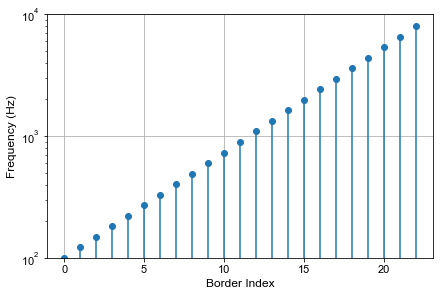

In [4]:
# plot border frequencies for CI with 22 electrodes
fig = plt.figure(constrained_layout=True)
plot = plt.stem(ci_22.f_border, use_line_collection=True, basefmt="")
plt.xlabel("Border Index")
plt.ylabel("Frequency (Hz)")
plt.yscale("log")
plt.ylim(1e2,1e4)
plt.show()
fig.savefig(f"../figures/borders_CI_22.pdf")

##  Subtask 2 - Implement a Filter Bank 

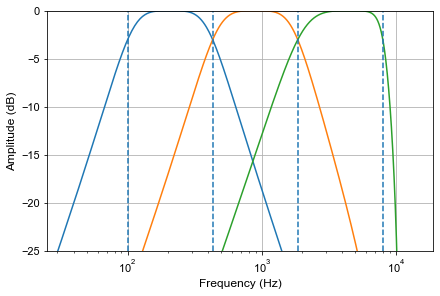

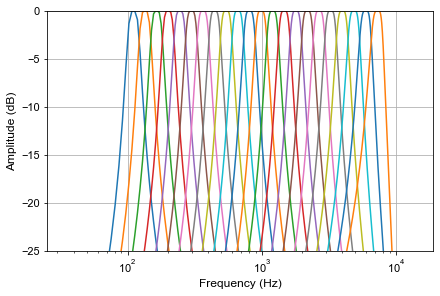

In [5]:
# plot frequency responses of filter banks
ci_3.plot_freq_response(show_borders=True)
ci_22.plot_freq_response()

In [16]:
import sounddevice as sd
from scipy.io.wavfile import read, write

def record(name, duration, f_sampling=44100):
    print(f"--- recording for {duration} seconds ---")
    rec = sd.rec(int(duration * f_sampling), samplerate=f_sampling, channels=2)
    sd.wait()
    write(f"../audio/{name}.wav", f_sampling, rec)

def load_and_plot(name, play=False, save=False):
        
    f_sampling, rec = read(f"../audio/{name}.wav")
    
    # convert to np array and use only one channel
    rec = np.array(rec, dtype=float)
    rec = rec[:,0]
    
    if play:
        sd.play(rec)
    
    dt = 1/f_sampling
    t = np.arange(0, len(rec) * dt, dt)
    
    # plot amplitude 
    fig1 = plt.figure(constrained_layout=True)
    plt.plot(t, rec)
    plt.title(f"Amplitude of word: {name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.xlim(0, len(rec) * dt)
    plt.show()
    
    # plot power spectrum 
    fig2 = plt.figure(constrained_layout=True)
    freqs, psd = signal.periodogram(rec, f_sampling)
    plt.semilogx(freqs, psd)
    plt.title(f"Power spectrum of word: {name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB/Hz)")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlim(ci_3.f_lowest, ci_3.f_highest)
    plt.show()
    
    # plot spectogram 
    fig3 = plt.figure(constrained_layout=True)
    frequencies, times, spectrogram = signal.spectrogram(rec, 
                                                         f_sampling, 
                                                         window=('tukey', 0.01*f_sampling), 
                                                         noverlap=np.round(0.005*f_sampling))
    spectrogram = np.log(spectrogram)
    cmap = plt.get_cmap('jet')
    plot = plt.pcolormesh(times, frequencies, spectrogram, cmap=cmap)
    plt.title(f"Spectrogram of word: {name}")
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.xlim(0, len(rec) * dt)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.ylim(ci_3.f_lowest, ci_3.f_highest)   
    plt.yscale("log")
    cbar = fig3.colorbar(plot)
    cbar.set_label("dBFS")
    plt.show()
    
    if save:
        fig1.savefig(f"../figures/amplitude_{name}.png", dpi=500)
        fig2.savefig(f"../figures/spectrum_{name}.png", dpi=500)
        fig3.savefig(f"../figures/spectrogram_{name}.png", dpi=500)

    return rec, f_sampling, frequencies, times, spectrogram

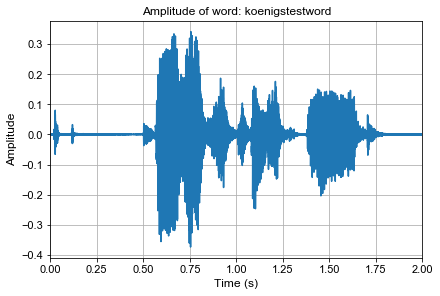

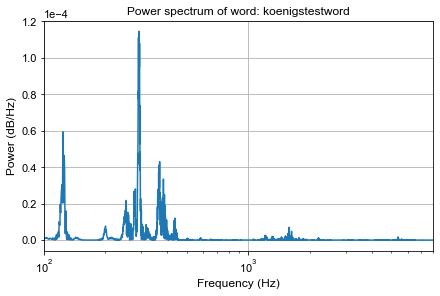

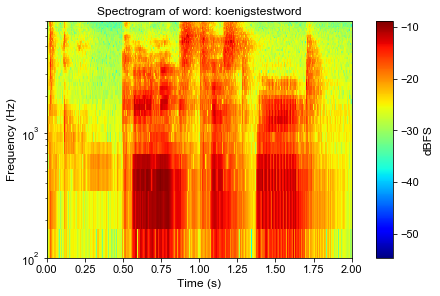

In [17]:
rec, f_sampling, frequencies, times, spectrogram = load_and_plot("koenigstestword", play=False, save=True)

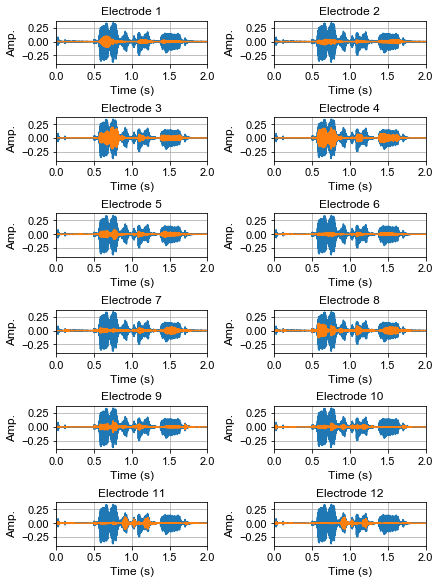

In [8]:
# filter sound in 12 electrode array
filtered_rec = ci_12.filter_sound(rec, f_sampling=f_sampling)
sd.play(filtered_rec[3])

# plot
ncols = 2
nrows = 6
ampl_max = 0.35

fig, axs = plt.subplots(6, 2, figsize=(6,8), constrained_layout=True)

dt = 1/f_sampling
t = np.arange(0, len(rec) * dt, dt)
i = 0

for r in range(nrows):
    for c in range(ncols):
        axs[r,c].plot(t, rec)
        axs[r,c].plot(t, filtered_rec[i])
        axs[r,c].set_title(f"Electrode {i+1}")
        axs[r,c].set_xlabel("Time (s)")
        axs[r,c].set_ylabel("Amp.")
        axs[r,c].set_xlim(0, len(rec) * dt)
        i +=1
    
plt.show()
fig.savefig(f"../figures/filtered_all.png", dpi=500)

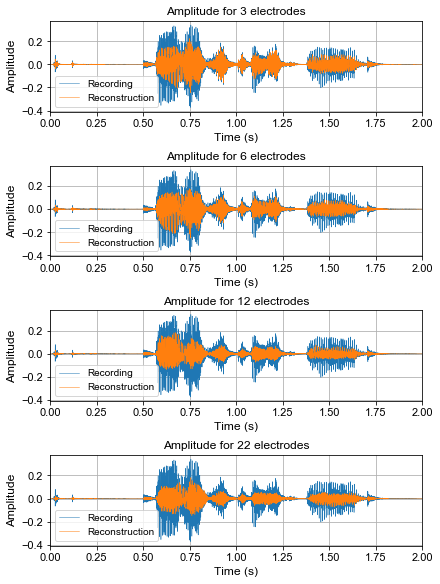

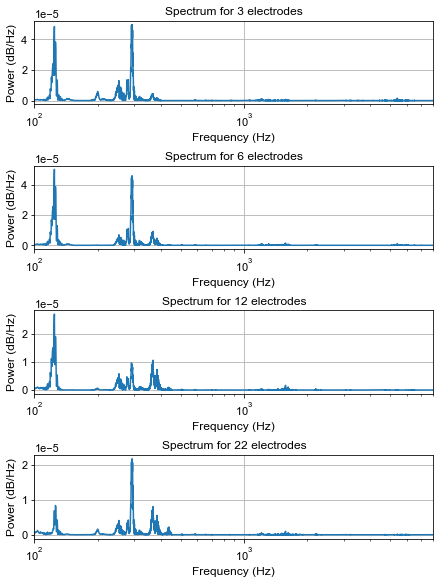

In [9]:
# compare implants
implants = [ci_3, ci_6, ci_12, ci_22]
  
# plot amplitude of original and reconstructed signal 
fig, axs = plt.subplots(4, 1, figsize=(6,8), constrained_layout=True)
i = 0
for implant in implants:
    filtered_rec = implant.filter_sound(rec, f_sampling=f_sampling)
    sum_rec = np.sum(filtered_rec, axis=0)
    axs[i].plot(t, rec, linewidth=0.5, label="Recording")
    axs[i].plot(t, sum_rec, linewidth=0.5, label="Reconstruction")
    axs[i].set_title(f"Amplitude for {implant.electrodes} electrodes")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Amplitude")
    axs[i].set_xlim(0, len(rec) * dt)
    axs[i].legend()
    i += 1

plt.show()
fig.savefig(f"../figures/amplitude_sum.png", dpi=500)
    
# plot spectra
fig, axs = plt.subplots(4, 1, figsize=(6,8), constrained_layout=True)
i = 0
for implant in implants:
    filtered_rec = implant.filter_sound(rec, f_sampling=f_sampling)
    sum_rec = np.sum(filtered_rec, axis=0)
    freqs, psd = signal.periodogram(sum_rec, f_sampling)
    axs[i].semilogx(freqs, psd)
    axs[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[i].set_title(f"Spectrum for {implant.electrodes} electrodes")
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Power (dB/Hz)")
    axs[i].set_xlim(implant.f_lowest, implant.f_highest)
    i += 1

plt.show()
fig.savefig(f"../figures/spectra.png", dpi=500) 

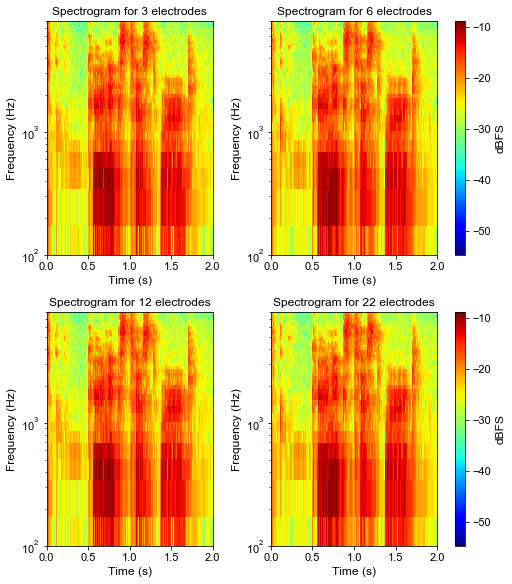

In [10]:
# plot spectra
fig, axs = plt.subplots(2, 2, figsize=(7,8), constrained_layout=True)
r = 0
c = 0
i = 0

for implant in implants:
    filtered_rec = implant.filter_sound(rec, f_sampling=f_sampling)
    sum_rec = np.sum(filtered_rec, axis=0)
    frequencies, times, spectrogram = signal.spectrogram(rec, 
                                                         f_sampling, 
                                                         window=('tukey', 0.01*f_sampling), 
                                                         noverlap=np.round(0.005*f_sampling))
    spectrogram = np.log(spectrogram)
    cmap = plt.get_cmap('jet')
    plot = axs[r,c].pcolormesh(times, frequencies, spectrogram, cmap=cmap)
    axs[r,c].set_title(f"Spectrogram for {implant.electrodes} electrodes")
    axs[r,c].set_ylabel('Frequency (Hz)')
    axs[r,c].set_xlabel('Time (s)')
    axs[r,c].set_xlim(0, len(rec) * dt)
    axs[r,c].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[r,c].set_ylim(ci_3.f_lowest, ci_3.f_highest)   
    axs[r,c].set_yscale("log")
    if i == 1 or i == 3:
        cbar = fig.colorbar(plot, ax=axs[r,c])
        cbar.set_label("dBFS")
    
    i += 1
    if i == 1:
        r = 0
        c = 1
    elif i == 2:
        r = 1
        c = 0
    elif i == 3:
        r = 1
        c = 1

plt.show()
fig.savefig(f"../figures/spectrograms.png", dpi=500) 